In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import math
import warnings
df = pd.read_csv('train.csv')
[df['month'],df['day'],df['year']] = [[float(df['id'][i].split('/')[j]) for i in range(df.shape[0])] for j in [0,1,2]]
M = 10
df = df.sort_values(by =['year','month'])

In [2]:
def get(phix,m):     # Returns phi only upto the no. of features 0 to m-1
    newphi = np.copy(phix.T)
    newphi = newphi[0:m]
    return newphi.T

def plot_all(x,hs,xl = 'X',yl = 'Y',legends = [''],xlog = False,scatterFirst = False, ylog = False):      # Plots all curves with x on X and all elements oh hs on Y, ll = xlabel, yl = ylabel, xlog = if x is on logarithmic scale, legends = legends
    plt.figure()
    plt.xlabel(xl)
    plt.ylabel(yl)
    if(xlog):
        plt.xscale('log')
    if(ylog):
        plt.yscale('log')
    if(scatterFirst):
        plt.scatter(x,hs[0],color = 'indigo')
    for h in hs[scatterFirst:]:
        plt.plot(x,h)
    plt.legend(legends)
    plt.show()

def make_batches(phix,tx,bs):                 # Returns the batches of phi,t with batch_size = bs
    N = phix.shape[0]
    newphi = np.copy(phix)
    newphi = np.concatenate((newphi,np.array([tx]).T),axis = 1)
    np.random.shuffle(newphi)
    sz = math.floor(N/bs)
    # print(sz,bs)
    newphi = newphi[0:sz*bs]
    N = phix.shape[0]
    newphi = np.array(np.split(newphi,sz))
    phis = []
    ts = []
    for ph in newphi:
        ts.append(ph.T[-1])
        phis.append((ph.T[0:-1]).T)
    return phis,ts

def MPPI(phi, t, m, lamda):
    phix = get(phi,m)
    wm = (( np.linalg.inv(lamda*np.eye(m) + (phix.T).dot(phix)).dot(phix.T)).dot(t))
    h = phix.dot(wm)
    return wm,h

def L1


def SSE(hi,ti):   # Returns Sum of Squares error between the hypothesis h and the target t
    N = hi.shape[0]
    cost = (1/N)*0.5*sum(np.square(hi-ti))
    return cost

def SSG(phii,ti,h,lamda,w):
    N = ti.shape[0]
    gd = np.dot(phii.T,h-ti)/N + lamda*w
    return gd

def batch_gd(phi, alpha, tx, iters, batch_size, m,lamda =0, errorf = SSE, gradient= SSG):
    phix = get(phi,m)
    w = np.ones(m,dtype = 'float')
    M = phix.shape[1]       # Number of features
    N = batch_size          # Number of data points
    for i in range(iters):
        phis,ts = make_batches(phix,tx,batch_size)
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                for i in range(len(phis)):
                    phii = phis[i]
                    ti = ts[i]
                    h = phii.dot(w)

                    gd = gradient(phii,ti,h,lamda,w)

                    w = w - (alpha * gd)

                    h = phii.dot(w)
            except RuntimeWarning as e:
                return e
    h = phix.dot(w)
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            cost = errorf(h,tx)
        except RuntimeWarning as e:
            return e
    return w,cost,h

def check(phi,t,m):
    N = phi.shape[0]
    batch_sizes =[]
    alphas = []
    for bs in [1,2,5,10,20,50,100]:
        batch_sizes.append(bs)
        alpha,cost = find_alpha(phi,t,bs,1e-5,1,m)
        alphas.append(alpha,cost)
        print(bs,alphas[-1])
    plt.plot(batch_sizes,alphas)

def find_alpha(phi,t,batch_size,l,r,lamda,m,errorf):
    mid = 0
    cost = 0
    for _ in range(5):
        mid = (l+r)/2
        output = batch_gd(phi,mid,t,10000,batch_size,lamda = lamda,m = m)
        if(isinstance(output,RuntimeWarning)):
            r = mid
        elif(output[1] > 1e6):
            r = mid
        else:
            cost = output[1]
            l =mid
    return l,cost

def Cross_Validation(phi,tx,alpha,parts,lamda,m,batch_size = 1,iters=5000,errorf=SSE,gradient=SSG,pinv = True):   # Finds cross validation Error for the given arguments
    # print(m,lamda)
    phix = get(phi,m)
    N = phix.shape[0]
    bs = math.floor(N/parts)
    alls = np.array_split(range(N),parts)
    test_error = 0.0
    training_error = 0.0
    for i in range(parts):
        phii = np.delete(phix,alls[i],axis = 0)
        ti = np.delete(tx,alls[i])
        if(pinv):
            wi,hi = MPPI(phii,ti,m,lamda)   
            costi = SSE(hi,ti)      # Represents the training error
        else:
            wi,costi,hi = batch_gd(phi = phii, alpha = alpha,tx = ti,batch_size= batch_size,lamda = lamda, iters = iters,m = m)
        # Wi and Hi are weights and hypothesis values at all inputs in this training set
        hypothesis_i = phix[alls[i]].dot(wi)    # Represents the hypothesis values at the test set
        training_error += costi # Increment total training error
        test_error += SSE(hypothesis_i,tx[alls[i]]) # Increment total testing error
    test_error /= parts
    training_error /= parts
    test_error = math.sqrt(test_error)
    training_error = math.sqrt(training_error)
    print(test_error,training_error)
    return test_error,training_error

In [3]:
x1 = np.array(df['year'])
x2 = np.array(df['month'])
x1 = np.array([x1[i] - 5 for i in range(len(x1))])
x2 = np.array([x2[i] - 1 for i in range(len(x2))])
t = np.array(df['value'])
x3 = np.array([x1[i]*12 + x2[i] for i in range(x1.shape[0])])
phi = np.array([[pow(xv,i) for i in range(M)] for xv in x3])
months= []
years = []
for j in range(0,12):
    month = []
    for i in range(x1.shape[0]):
        if(x2[i] == j):
            month.append(i)
    months.append(month)

qtrs= []
for j in range(1,5):
    qtr = []
    for i in range(x1.shape[0]):
        if(x2[i] <= j*4 and x2[i] > (j-1)*4):
            qtr.append(i)
    qtrs.append(qtr)

for j in range(0,11):
    qtr = []
    year = []
    for i in range(x1.shape[0]):
        if(x1[i] == j):
            year.append(i)
    years.append(year)
print(phi.shape)

(110, 10)


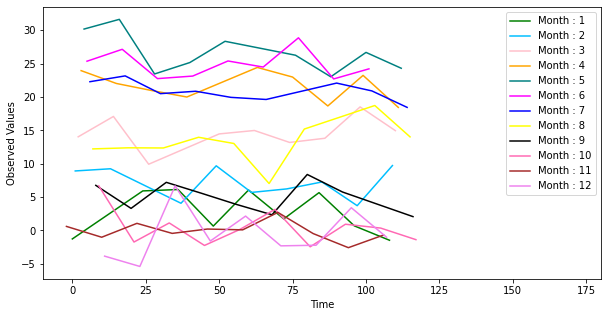

In [15]:
plt.figure(figsize = (10,5))
plt.xlabel("Time")
plt.ylabel("Observed Values")
plt.xlim(-10,180)
plt.plot(x3[months[0]],t[months[0]],'green') # 9
plt.plot(x3[months[1]],t[months[1]],'deepskyblue') # 7
plt.plot(x3[months[2]],t[months[2]],'pink') # 5
plt.plot(x3[months[3]],t[months[3]],'orange') # 3
plt.plot(x3[months[4]],t[months[4]],'teal') # 1
plt.plot(x3[months[5]],t[months[5]],'magenta') # 2
plt.plot(x3[months[6]],t[months[6]],'blue') # 4
plt.plot(x3[months[7]],t[months[7]],'yellow') # 6
plt.plot(x3[months[8]],t[months[8]],'black') # 8
plt.plot(x3[months[9]],t[months[9]],'hotpink') # 10
plt.plot(x3[months[10]],t[months[10]],'brown') # 12
plt.plot(x3[months[11]],t[months[11]],'violet') # 11
plt.legend([f"Month : {i}" for i in range(1,13)])
plt.show()

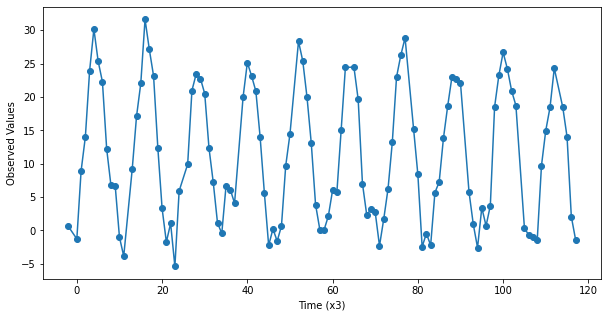

In [7]:
# m3456 = months[3] + months[4] + months[5] + months[6]
# sort(m3456)
plt.figure(figsize=(10,5))
plt.xlabel("Time (x3)")
plt.ylabel("Observed Values")
plt.scatter(x3,t)
plt.plot(x3,t)

In [9]:
errors = [Cross_Validation(phi,t, alpha = 1e-4, batch_size = 1, parts = 10, lamda = 0, m = i, pinv = False) for i in range(2,25)]

KeyboardInterrupt: 

In [16]:
weights = []
hyps = []
for i in range(12):
    weight,hyp = MPPI(phi[months[i]],t[months[i]],8,1e-4)
    # print(i)
    # weight,costi,hyp = batch_gd(phi = phi[months[i]],tx = t[months[i]], m = 3, alpha = 1e-4, lamda = 0, iters= 5000)
    weights.append(weight)
    hyps.append(hyp)
weights = np.array(weights)
hyps = np.array(hyps)

<ipython-input-16-22e1db3e09b8>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hyps = np.array(hyps)


In [17]:
m1 = 6
test_all = np.zeros(m1-1)
train_all = np.zeros(m1-1)
for mt in range(12):
    # print('Month : ',mt)
    sz = len(months[mt])
    errors = [Cross_Validation(phi[months[mt]],t[months[mt]], alpha = 1e-4, batch_size = 1, parts = sz, lamda = 1e-4, m = i, pinv = True) for i in range(1,m1)]
    test,train = np.copy(np.array(errors)).T
    # plot_all(x = range(m1-1), hs = [test,train],  legends = ['Testing','Training'], xl ='Degree of Polynomial', yl ='Error',)
    test_all += test
    train_all += train
test_all /= 12
train_all /= 12
print("Cumulative Errors")
# plot_all(x = range(m1-1), hs = [test_all,train_all],  legends = ['Testing','Training'], xl ='Degree of Polynomial', yl ='Error',)

2.437730237739037 2.149878976777167
3.1246510158764043 2.0795235524477103
2.407742398887958 1.5119810179987212
5.173565985497842 1.4557675331991526
4.916223052560638 1.2184588967862169
1.7750512488157844 1.5654502307495637
2.0255682568693953 1.4993397774505823
2.180502431994711 1.3514360810319026
2.9010598767072886 1.2964030025052016
5.20143595774514 1.1523054937388388
1.8087830475499023 1.5951989231747146
2.012684738516759 1.513933253221019
2.185984656568204 1.4327112851244308
3.0443356443680396 1.3646215676955182
5.0142408281278525 1.2911428860389615
1.6753544829856153 1.477525828128187
1.7704179159127327 1.3678860065878726
2.2369008430062562 1.3304178876723045
1.7629688936731747 1.125890321569141
3.4333710555699155 1.0515557384590368
2.239541392477163 1.9750926046939408
2.0596937611907564 1.6012482651625237
2.0949135354172985 1.5029029741882218
2.4135979488692114 1.4288788521170344
5.0362701129325105 1.3458361976131548
1.5556618482199622 1.3719667009066288
1.7137605920986347 1.35550

Month:  1
[-0.20712377  0.19835763 -0.0019271 ]
Month:  2
[7.16462039]
Month:  3
[13.50895855  0.01782399]
Month:  4
[ 2.45219035e+01 -2.50045645e-01  5.45296109e-03 -3.30796316e-05]
Month:  5
[ 3.06565954e+01 -1.31108024e-01  7.41205962e-04]
Month:  6
[24.88812347]
Month:  7
[ 2.15124129e+01  2.20971284e-01 -1.22662187e-02  1.86922254e-04
 -8.63832138e-07]
Month:  8
[11.21828017  0.03448951]
Month:  9
[ 5.24741404e+00  2.09949542e-02 -3.24692372e-04]
Month:  10
[ 9.45038704e+00 -5.52301559e-01  9.05154710e-03 -4.40010867e-05]
Month:  11
[-0.15720417  0.03391605 -0.00042752]
Month:  12
[-5.12197419e+00  1.70902379e-01 -1.22195660e-03]


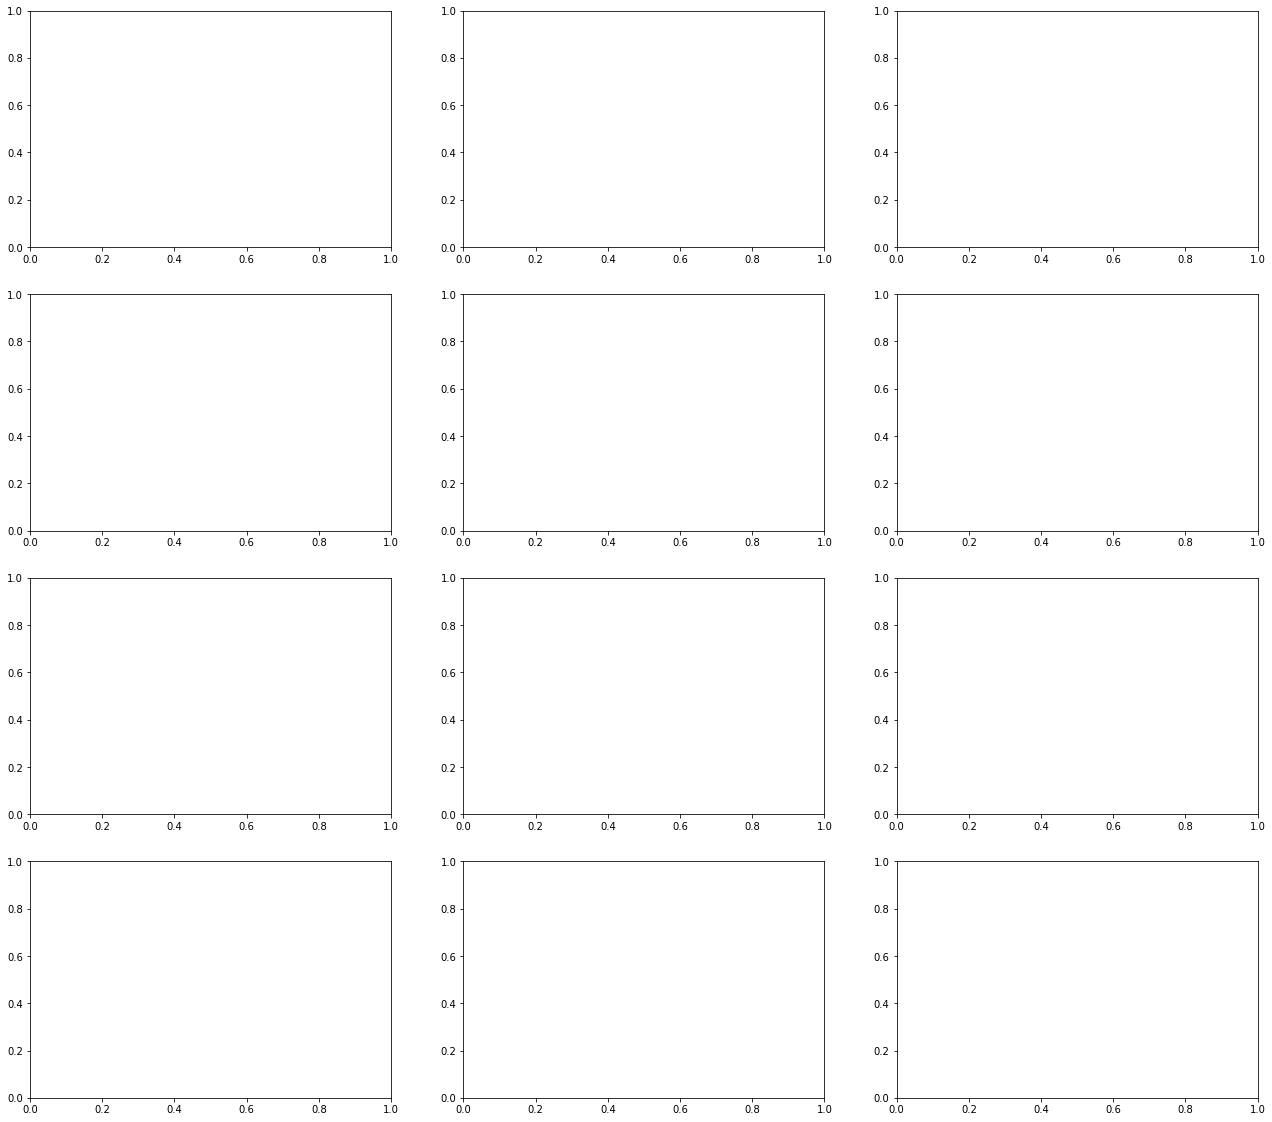

In [45]:
degrees = [2,0,1,3,2,0,4,1,2,3,2,2]
ms = [deg + 1 for deg in degrees]
ws = []
hys = []
fig,axs = plt.subplots(4,3,figsize=(22,20))

for i in range(12):
    print("Month: ",i+1)
    wt,hypt = MPPI(phi[months[i]],t[months[i]],ms[i],1e-4)
    print(wt)
    # errs = [Cross_Validation(phi[months[i]],t[months[i]], alpha = 1e-4, batch_size = 1, parts = sz, lamda = 0, m = j, pinv = True) for j in range(1,7)]
    # tr,ts = np.array(errs).T
    # r = int(i/3)
    # c = i%3
    # print(r,c)
    # axs[r,c].plot(range(0,6),tr)
    # axs[r,c].plot(range(0,6),ts)
    # axs[r,c].set_title(f"Month {i+1}")
    # axs[r,c].set(xlabel ='Degree of Polynomial',ylabel='CVS')

    # axs[r,c].legend(["Testing","Training"])
    ws.append(wt)
    # hy = get(phi[months[i]],ms[i]).dot(wt)

# fig.show()

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')
#     hys.append(hy)

In [47]:
print(ws)
ans2 = []
df1 = pd.read_csv('test.csv')
[df1['month'],df1['day'],df1['year']] = [[float(df1['id'][i].split('/')[j]) for i in range(df1.shape[0])] for j in [0,1,2]]
print(weights[0])
for i in range(10):
    mth = int(df1['month'][i]) - 1
    year = int(df1['year'][i]) - 5
    tim = mth + year*12
    phit = np.array([pow(tim,i) for i in range(0,ms[mth])])
    print(df1['id'][i],end= '')
    print(',',end = '')
    print(phit.dot(ws[mth]))
    ans2.append(phit.dot(ws[mth]))

[array([-0.20712377,  0.19835763, -0.0019271 ]), array([7.16462039]), array([13.50895855,  0.01782399]), array([ 2.45219035e+01, -2.50045645e-01,  5.45296109e-03, -3.30796316e-05]), array([ 3.06565954e+01, -1.31108024e-01,  7.41205962e-04]), array([24.88812347]), array([ 2.15124129e+01,  2.20971284e-01, -1.22662187e-02,  1.86922254e-04,
       -8.63832138e-07]), array([11.21828017,  0.03448951]), array([ 5.24741404e+00,  2.09949542e-02, -3.24692372e-04]), array([ 9.45038704e+00, -5.52301559e-01,  9.05154710e-03, -4.40010867e-05]), array([-0.15720417,  0.03391605, -0.00042752]), array([-5.12197419e+00,  1.70902379e-01, -1.22195660e-03])]
[-1.28338870e+00 -1.96554327e-01  8.32307700e-02 -4.33694742e-03
  9.36228729e-05 -9.77790979e-07  4.81182522e-09 -8.70920591e-12]
5/1/10,25.301661525582315
4/1/09,21.564681218380365
9/1/13,3.919016577690215
1/1/06,1.8956650004058684
2/1/07,7.164620393106743
8/1/12,14.356825746539862
6/1/14,24.888123465294832
3/1/08,14.18627012584729
12/1/04,-5.29409852

In [20]:
# Cross Validating to find best values of lamda for each curve
lamda_high = 15
lamdas1 = [pow(10,i) for i in range(-15,lamda_high)]
test_all = np.zeros(lamda_high +15)
train_all = np.zeros(lamda_high+15)
for mt in range(12):
    # print('Month : ',mt)
    sz = len(months[mt])
    errors = [Cross_Validation(phi[months[mt]],t[months[mt]], alpha = 1e-4, batch_size = 1, parts = sz, lamda = i, m = ms[mt], pinv = True) for i in lamdas1]
    test,train = np.copy(np.array(errors)).T
    # plot_all(x = lamdas1, xlog = True, hs = [test,train],  legends = ['Testing','Training'], xl ='Lamda', yl ='Error',)
    test_all += test
    train_all += train
test_all /= 12
train_all /= 12
# print("Cumulative Errors")
# plot_all(lamdas1, hs = [test_all,train_all],  legends = ['Testing','Training'], xl ='Lamda', yl ='Error',)

2.4080399894004874 1.511981015664566
2.4080399894004594 1.5119810156645663
2.4080399894001965 1.5119810156645663
2.4080399893975217 1.5119810156645663
2.408039989370737 1.5119810156645663
2.4080399891027513 1.5119810156645663
2.4080399864228927 1.511981015664566
2.4080399596245794 1.5119810156645663
2.40803969164153 1.5119810156645683
2.4080370118260204 1.5119810156647997
2.408010215173943 1.5119810156879268
2.407742398887958 1.5119810179987212
2.4050791811213337 1.5119812472003853
2.3798668563169163 1.51200240939924
2.2201474004499038 1.5130968571095498
1.9928965008967774 1.5205289246906555
1.932236742112367 1.526736407873111
1.9172570878012467 1.531322110174388
2.055778414026748 1.6860086872608968
2.82204316183972 2.3790951976585215
3.110620133867276 2.64956423105964
3.1429062334145335 2.6834823815607862
3.115185353286909 2.687263679133672
2.9474715713572937 2.7034442599478816
2.847921099278736 2.8076719170103765
2.870516295857079 2.866256661825587
2.8749056965935997 2.87447666069891

In [40]:
lams = [pow(10,i) for i in [-2,-2,-1,-3,-2,-2,-3,-1,2,-2,-2,-2]]

In [41]:
ws1 = []
hys1 = []
for i in range(12):
    wt,hy = MPPI(phi[months[i]],t[months[i]],ms[i],lams[i])
    # print(i)
    # weight,costi,hyp = batch_gd(phi = phi[months[i]],tx = t[months[i]], m = 3, alpha = 1e-4, lamda = 0, iters= 5000)
    ws1.append(wt)
    hys1.append(hy)
weights = np.array(weights)
hyps = np.array(hyps)

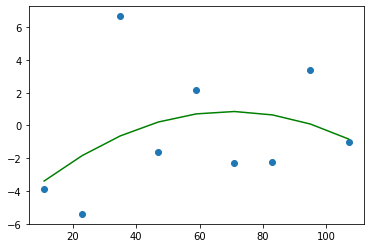

In [16]:
mh = 11
plt.scatter(x3[months[mh]],t[months[mh]])
plt.plot(x3[months[mh]],hys[mh],'green')

In [43]:
# Submit in the morning
ans3 = []
df1 = pd.read_csv('test.csv')
[df1['month'],df1['day'],df1['year']] = [[float(df1['id'][i].split('/')[j]) for i in range(df1.shape[0])] for j in [0,1,2]]
print(weights[0])
for i in range(10):
    mth = int(df1['month'][i]) - 1
    year = int(df1['year'][i]) - 5
    tim = mth + year*12
    phit = np.array([pow(tim,i) for i in range(0,ms[mth])])
    print(df1['id'][i],end= '')
    print(',',end = '')
    print(phit.dot(ws1[mth]))
    ans3.append(phit.dot(ws1[mth]))

[-1.28338870e+00 -1.96554327e-01  8.32307700e-02 -4.33694742e-03
  9.36228729e-05 -9.77790979e-07  4.81182522e-09 -8.70920591e-12]
5/1/10,25.36307261570625
4/1/09,21.569789606456748
9/1/13,3.840410214700091
1/1/06,1.8967665580262618
2/1/07,7.385706291438806
8/1/12,14.296256616759699
6/1/14,24.533837326506017
3/1/08,13.528295223976091
12/1/04,-5.215933819175435
7/1/11,20.844426685935204


In [94]:
ans = 100*np.ones(10)
an2 = np.copy(ans2)
an3 = np.copy(ans3)
print(np.sum(np.square(ans-an3)))
print(20*SSE(ans,an2))
print(20*SSE(an2,an3))

75942.620124087
77032.16561402846
28.089793943558803


|correct - 100|*2 = 7507

|ans2 - 100|*2 = 7594

(ans2 - 100)2 - (c-100)2 = (7594 - 7507)*2 = 174
(105.3)2 - 174 = (c-100)2
c-100 = -104.47
c = -4.47


2.2338051418215813e-06
